
# Latent Dirichlet Allocation(LDA) for 'Customer interest' modelling


#### Import libraries

In [2]:
# !pip install pyLDAvis 

In [3]:
# import libraries 
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gensim
from gensim import corpora

In [4]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


####   Dataset Analysis

In [5]:
# Read data from csv
customer_review_data= pd.read_csv("amazon_alexa - amazon_alexa.csv")
print(customer_review_data.head(2))
print(len(customer_review_data))
print('Number of Unique variation')
print(len(customer_review_data.groupby('variation')))

   rating       date        variation verified_reviews  feedback
0       5  31-Jul-18  Charcoal Fabric    Love my Echo!         1
1       5  31-Jul-18  Charcoal Fabric        Loved it!         1
3150
Number of Unique variation
16


In [6]:
# Clean text
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text2.lower()

In [7]:
# In natural language processing, useless words (data), are referred to as stop words. 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# Removes the rows that contains NULL values.
customer_review_data.dropna(axis = 0, how ='any',inplace=True) 

####   Filter short reviews according to rating

In [9]:
customer_review_data['verified_reviews'] = customer_review_data['verified_reviews'].apply(clean_text)
customer_review_data['Num_words_text'] = customer_review_data['verified_reviews'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(customer_review_data['rating'].value_counts())
print(len(customer_review_data))
print('-------------------------')
max_review_data_sentence_length  = customer_review_data['Num_words_text'].max()

mask = (customer_review_data['Num_words_text'] < 100) & (customer_review_data['Num_words_text'] >=20)
df_short_reviews = customer_review_data[mask]
df_new = df_short_reviews.groupby('rating').apply(lambda x: x.sample(n=40)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    2246
4     447
1     146
3     140
2      92
Name: rating, dtype: int64
3071
-------------------------
No of Short reviews
640


In [10]:
df_short_reviews

,rating,date,variation,verified_reviews,feedback,Num_words_text
2,4,31-Jul-18,Walnut Finish,sometimes while playing game answer question c...,1,21
6,3,31-Jul-18,Sandstone Fabric,without having cellphone cannot many features ...,1,33
7,5,31-Jul-18,Charcoal Fabric,think this purchased working getting every roo...,1,22
12,5,30-Jul-18,Oak Finish,purchased this mother having knee problems giv...,1,30
17,5,30-Jul-18,Heather Gray Fabric,have only been using alexa couple days having ...,1,21
...,...,...,...,...,...,...
3101,5,30-Jul-18,Black Dot,these additional alexa based devices make acce...,1,27
3110,5,30-Jul-18,White Dot,love personally prefer spotify music it’s grea...,1,46
3129,4,30-Jul-18,White Dot,have these throughout home they great there ti...,1,38
3147,5,30-Jul-18,Black Dot,love these things have them running entire hom...,1,49


In [11]:
df_new

,rating,date,variation,verified_reviews,feedback,Num_words_text
0,1,24-Jul-18,White Spot,great product except there possible clock disp...,0,43
1,1,29-Jul-18,Black Show,returned from repair with repair done problem ...,0,34
2,1,30-Jul-18,Black Show,waste money over echo generation don’t really ...,0,60
3,1,29-Jun-18,Black Plus,this months with idea that will help control s...,0,56
4,1,26-Jul-18,Black Spot,would love this there stop screen from constan...,0,21
...,...,...,...,...,...,...
195,5,30-Jul-18,Walnut Finish,great getting know functions this product fami...,1,24
196,5,8-Jun-18,White,useful were still learning tricks useful funct...,1,22
197,5,30-Jul-18,Configuration: Fire TV Stick,easy lots things watch program have even gotte...,1,21
198,5,30-Jul-18,Heather Gray Fabric,little nervous when received echo really tech ...,1,23


####   Dataset Pre-processing

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_new['verified_reviews']=df_new['verified_reviews'].apply(remove_stopwords)

In [13]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# create a lemmatization for filtering
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

#### Finding Nouns and Adjectives

In [14]:
text_list=df_new['verified_reviews'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

returned repair repair done problem requires defective part show itselfi sent repair back without fixed site gives option complain pagei echo spot works perfectly position
['repair', 'repair', 'problem', 'defective', 'part', 'itselfi', 'repair', 'site', 'option', 'pagei', 'echo', 'spot', 'position']


#### Dictionary and Document term matrix

In [15]:
# Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

####  LDA model

In [16]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [17]:
# Build LDA model
num_topics=40
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=10,
                chunksize=100, passes=50,iterations=100)

In [18]:
lda_model.print_topics(num_topics)

[(0,
  '0.039*"respond" + 0.038*"speaker" + 0.037*"echo" + 0.031*"front" + 0.030*"bedside" + 0.029*"prime" + 0.026*"screen" + 0.023*"setting" + 0.023*"type" + 0.023*"button"'),
 (1,
  '0.001*"course" + 0.001*"sized" + 0.001*"boring" + 0.001*"sneaky" + 0.001*"lightbulb" + 0.001*"keep" + 0.001*"desk" + 0.001*"alexia" + 0.001*"senior" + 0.001*"booksthe"'),
 (2,
  '0.080*"music" + 0.075*"different" + 0.062*"right" + 0.050*"movie" + 0.045*"happy" + 0.040*"fire" + 0.033*"time" + 0.024*"app" + 0.022*"slow" + 0.017*"work"'),
 (3,
  '0.068*"number" + 0.061*"access" + 0.059*"phone" + 0.054*"call" + 0.044*"kind" + 0.036*"link" + 0.035*"money" + 0.031*"device" + 0.031*"service" + 0.026*"direct"'),
 (4,
  '0.040*"today" + 0.036*"echo" + 0.035*"show" + 0.033*"shopping" + 0.032*"item" + 0.031*"impressed" + 0.025*"list" + 0.025*"work" + 0.024*"easy" + 0.024*"wife"'),
 (5,
  '0.071*"fault" + 0.055*"clear" + 0.037*"music" + 0.035*"cool" + 0.034*"amazon" + 0.032*"alexa" + 0.025*"device" + 0.025*"time" + 

#### Measureing the model

In [19]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=100))

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)



Perplexity:  -13.186308849329329

Coherence Score: 0.4205114619321068


#### Visualize the topics

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster      Freq
topic                                                                   
30    -0.229437+0.000000j  0.027857+0.000000j       1        1  9.328482
19    -0.197739+0.000000j  0.167452+0.000000j       2        1  7.337995
17    -0.132836+0.000000j -0.138284+0.000000j       3        1  6.480575
25    -0.173008+0.000000j  0.133681+0.000000j       4        1  5.313675
36    -0.044139+0.000000j -0.157670+0.000000j       5        1  4.226652
11    -0.094924+0.000000j -0.053643+0.000000j       6        1  3.981680
0     -0.108434+0.000000j -0.009783+0.000000j       7        1  3.812636
35    -0.042426+0.000000j  0.002206+0.000000j       8        1  3.645112
4     -0.015702+0.000000j -0.006477+0.000000j       9        1  3.484537
37    -0.065316+0.000000j  0.005760+0.000000j      10        1  3.482062
9     -0.055177+0.000000j -0.023888+0.000000j      11        1  3.362463
18    -0.034198+0.00

#### Finding the best model 

In [21]:
# Compute c_v coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

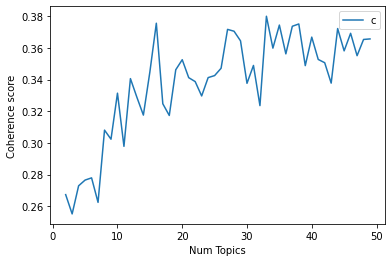

In [23]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [24]:
# Print the coherence scores
max_coherence=0
optimal_topics=0
index_model=0
i=0
for m, cv in zip(x, coherence_values):
    if(max_coherence<cv):
        index_model=i
        max_coherence=cv
        optimal_topics=m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i+=1
    
print("\n_____________________________________________________")   
print(index_model," :: "+"Optimal Topic number =", optimal_topics, " Coherence Scores =", round(max_coherence, 4))

Num Topics = 2  has Coherence Value of 0.2673
Num Topics = 3  has Coherence Value of 0.2551
Num Topics = 4  has Coherence Value of 0.2729
Num Topics = 5  has Coherence Value of 0.2765
Num Topics = 6  has Coherence Value of 0.2779
Num Topics = 7  has Coherence Value of 0.2624
Num Topics = 8  has Coherence Value of 0.3081
Num Topics = 9  has Coherence Value of 0.3023
Num Topics = 10  has Coherence Value of 0.3314
Num Topics = 11  has Coherence Value of 0.2978
Num Topics = 12  has Coherence Value of 0.3406
Num Topics = 13  has Coherence Value of 0.3288
Num Topics = 14  has Coherence Value of 0.3176
Num Topics = 15  has Coherence Value of 0.3447
Num Topics = 16  has Coherence Value of 0.3756
Num Topics = 17  has Coherence Value of 0.3247
Num Topics = 18  has Coherence Value of 0.3173
Num Topics = 19  has Coherence Value of 0.3462
Num Topics = 20  has Coherence Value of 0.3525
Num Topics = 21  has Coherence Value of 0.3412
Num Topics = 22  has Coherence Value of 0.3387
Num Topics = 23  has 

In [25]:
# Select the model and print the topics
optimal_model = model_list[index_model]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(30,
  '0.035*"try34" + 0.018*"enable" + 0.018*"happy" + 0.018*"activated" + 0.018*"screen" + 0.018*"question" + 0.018*"today" + 0.018*"dropping" + 0.018*"look" + 0.018*"spot"'),
 (21,
  '0.046*"echo" + 0.025*"display" + 0.025*"dot" + 0.025*"clock" + 0.024*"order" + 0.023*"small" + 0.022*"size" + 0.022*"spot" + 0.021*"love" + 0.013*"life"'),
 (3,
  '0.026*"show" + 0.024*"search" + 0.024*"regular" + 0.024*"sound" + 0.024*"ability" + 0.024*"information" + 0.017*"screen" + 0.016*"little" + 0.016*"dot" + 0.016*"easy"'),
 (32,
  '0.027*"great" + 0.022*"device" + 0.022*"music" + 0.022*"work" + 0.016*"voice" + 0.016*"basic" + 0.016*"echo" + 0.011*"hour" + 0.011*"item" + 0.011*"speech"'),
 (11,
  '0.030*"alarm" + 0.020*"world" + 0.020*"night" + 0.020*"phone" + 0.020*"music" + 0.014*"great" + 0.010*"device34" + 0.010*"slow" + 0.010*"readingglasse" + 0.010*"prime"'),
 (0,
  '0.060*"screen" + 0.036*"music" + 0.027*"device" + 0.021*"home" + 0.018*"video" + 0.015*"annoying" + 0.014*"feature" + 0.0

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
31    -0.134421 -0.039340       1        1  7.772555
9     -0.030192 -0.027220       2        1  6.371844
1     -0.087647 -0.089809       3        1  5.879034
4     -0.025945  0.020837       4        1  5.162586
0     -0.135829 -0.051624       5        1  5.014042
15    -0.062152  0.074394       6        1  4.963319
32    -0.062182 -0.053660       7        1  4.354742
5     -0.043894  0.096853       8        1  4.058507
12    -0.036846  0.003564       9        1  3.867290
24    -0.028822 -0.032015      10        1  3.761390
29    -0.100821  0.032654      11        1  3.663965
16    -0.045768  0.004154      12        1  3.468058
19     0.104711 -0.170155      13        1  3.346252
26    -0.094939  0.048701      14        1  3.274346
6      0.003567 -0.004020      15        1  3.066930
17     0.074913  0.137220      16        1  2.971273
22    -0.060750 -0.064166      17        1  2.830603
10     0.006540  0.044352      18        1  2.819425
8     -0.075132 -0.043122      19        1  2.755189
2      0.036070 -0.054650      20        1  2.518010
20    -0.004815  0.070743      21        1  2.461011
18    -0.044434  0.027744      22        1  2.230009
11     0.066231  0.081237      23        1  1.993246
13     0.076894 -0.060040      24        1  1.716378
21     0.077686  0.035615      25        1  1.688900
3      0.043033  0.013343      26        1  1.456294
23     0.087358  0.082231      27        1  1.349236
7      0.096067  0.029679      28        1  1.160382
30     0.057753 -0.004205      29        1  1.099339
25     0.135309 -0.154064      30        1  0.802069
28     0.045184  0.019434      31        1  0.769439
27     0.079362 -0.003218      32        1  0.709483
14     0.083913  0.028553      33        1  0.644850, topic_info=         Term       Freq      Total Category  logprob  loglift
33     device  73.000000  73.000000  Default  30.0000  30.0000
17       time  42.000000  42.000000  Default  29.0000  29.0000
93      music  60.000000  60.000000  Default  28.0000  28.0000
139     light  20.000000  20.000000  Default  27.0000  27.0000
70       work  24.000000  24.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
10   possible   0.013938   3.782106  Topic33  -7.3498  -0.5595
11    product   0.013938  25.267642  Topic33  -7.3498  -2.4587
12     rotate   0.013938   1.400056  Topic33  -7.3498   0.4343
13     screen   0.013938  27.109857  Topic33  -7.3498  -2.5291
14    several   0.013938   8.555438  Topic33  -7.3498  -1.3758

[1647 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
619       1  0.656254      342nd
863       5  0.648467      34hmm
88       10  0.783791       34im
229       8  0.405762      34the
229      18  0.405762      34the
...     ...       ...        ...
129       5  0.150715    youtube
985      23  0.722358  zonkedout
416       5  0.648461      zwave
986      23  0.722353    zzzzzzz
862      14  0.721210          ’

[2194 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[32, 10, 2, 5, 1, 16, 33, 6, 13, 25, 30, 17, 20, 27, 7, 18, 23, 11, 9, 3, 21, 19, 12, 14, 22, 4, 24, 8, 31, 26, 29, 28, 15])

#### Predict new review using trained model

In [27]:
# Enter customer review
input_review="I was a little nervous when I received my new Echo as I'm not really Tech savvy. I found it a bit intimidating at first but it didn't take me to long to figure it out!! I'm very happy with my purchase and now thinking of adding an echo spot!!!"

In [28]:
# Predicting the topic distribution for the given review
input_testing_review_list=[""]
input_testing_review_list[0]=input_review
tokenized_testing_reviews = lemmatization(input_testing_review_list)
# print(tokenized_testing_reviews[0])

# Tokenized_testing_reviews
new_doc_bow = dictionary.doc2bow(tokenized_testing_reviews[0])
predict_list=lda_model.get_document_topics(new_doc_bow)
predict_list

[(2, 0.14962183), (24, 0.15634014), (28, 0.17662777), (36, 0.3888335)]

In [29]:
# Finding predict topic
predict_topic_id=0
predict_probability=0

for topic in predict_list:
    if(predict_probability<topic[1]):
        predict_topic_id=topic[0]
        predict_probability=topic[1]
        
#Topic_id ,Probability
print("Topic_id =",predict_topic_id,"  Probability =",predict_probability)

Topic_id = 36   Probability = 0.3888335


#### All topics labels

In [54]:
# find all topic labels
x=lda_model.show_topics(num_topics=num_topics, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
topic_label_list_all=[]
#Below Code Prints Only Words 
for topic,words in topics_words:
    topic_label_list_all.append(" ".join(words))

In [55]:
# access train model to predict Neg and Pos
%cd ./Customer_reviews_classification(Pos&Neg).ipynb


[WinError 267] The directory name is invalid: './Customer_reviews_classification(Pos&Neg).ipynb'
E:\code\SENETIMENT_ANALYSIS_AMAZON\1\LDA_Customer_Interests_Modelling


In [63]:
pos_count=0
neg_count=0
final_topic_label_list_all=[]

for k in topic_label_list_all:
    y_pred=clf.predict(count_vectorizer.transform([k]))
    if(y_pred[0]==1):
        pos_count+=1
        final_topic_label_list_all.append(k+' -- POSITIVE')
    else:
        neg_count+=1
        final_topic_label_list_all.append(k+' -- NEGATIVE')
    

In [64]:
# Printing all labels
for (i, item) in enumerate(final_topic_label_list_all, start=1):
    print("Topic",i,"::",item)

Topic 1 :: respond speaker echo front bedside prime screen setting type button -- POSITIVE
Topic 2 :: course sized boring sneaky lightbulb keep desk alexia senior booksthe -- POSITIVE
Topic 3 :: music different right movie happy fire time app slow work -- POSITIVE
Topic 4 :: number access phone call kind link money device service direct -- POSITIVE
Topic 5 :: today echo show shopping item impressed list work easy wife -- POSITIVE
Topic 6 :: fault clear music cool amazon alexa device time find speaker -- POSITIVE
Topic 7 :: screen alexa video spotify control people try34 useful prime turn -- POSITIVE
Topic 8 :: course sized boring sneaky lightbulb keep desk alexia senior booksthe -- POSITIVE
Topic 9 :: course sized boring sneaky lightbulb keep desk alexia senior booksthe -- POSITIVE
Topic 10 :: room alarm turn living great question command frustrating time random -- POSITIVE
Topic 11 :: course sized boring sneaky lightbulb keep desk alexia senior booksthe -- POSITIVE
Topic 12 :: device 

In [68]:
#positive topics
print("Number of Positive topics =",pos_count)

Number of Positive topics = 37


In [69]:
#negative topics
print("Number of Negative topics =",neg_count)

Number of Negative topics = 3
